# Template Data Analysis Workflow - Visualization and kinetic modeling of enzymatic data

### Imports
Import packages needed for data analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import numpy as np 
import pyenzyme as pe

from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting

## Select EnzymeML document
Select the EnzymeML document, by changing the path variable accodingly. <br>
The EnzymeML document will be stored in the enzmldoc variable. <br>

In [ ]:
# If the document is a EnzymeML document 
round1 = pe.EnzymeMLDocument.fromFile("../round_one/UPO_with_Model.omex")
round2 = pe.EnzymeMLDocument.fromTemplate('./Hilberath_Round2_corrected.xlsm')

# If the document is from a spreadsheet 
#enzmldoc = EnzymeMLDocument.fromTemplate('path_to.xlsx')

## Print the Document to get a first overview

To get a first overview of the experiment. Information like IDs from reactants are printed.

In [7]:
# With measurements=True in parenthesis we can also print out the initial concentrations 
round1.printDocument()

UPO_with_Model
>>> Reactants
	ID: s0 	 Name: 1.3-bisphenoxypropan-2-ol
	ID: s1 	 Name: H2O2
	ID: s2 	 Name: unknown degradation products
	ID: s3 	 Name: H2O
	ID: s4 	 Name: L-ascorbic acid
>>> Proteins
	ID: p0 	 Name: rAaeUPO (PaDa-I)
>>> Complexes
>>> Reactions
	ID: r0 	 Name: UPO-mediated oxidation of 1.3-bisphenoxypropan-2-ol


In [8]:
round2.printDocument()

 AaeUPO  catalyzed oxidation of 1,3-bisphenoxypropanol - PoE
>>> Reactants
	ID: s0 	 Name: 1,3-bisphenoxypropan-2-ol
	ID: s1 	 Name: H2O2
	ID: s2 	 Name: unknown degradation products
	ID: s3 	 Name: H2O
	ID: s4 	 Name: L-ascorbic acid
	ID: s5 	 Name: 20 vol% ACN
>>> Proteins
	ID: p0 	 Name: rAaeUPO (PaDa-I)
>>> Complexes
>>> Reactions
	ID: r0 	 Name: UPO-mediated oxidation of 1,3-bisphenoxypropan-2-ol


## Visualization of time-course data
A short visualisation to get a first impression of the data. <br>

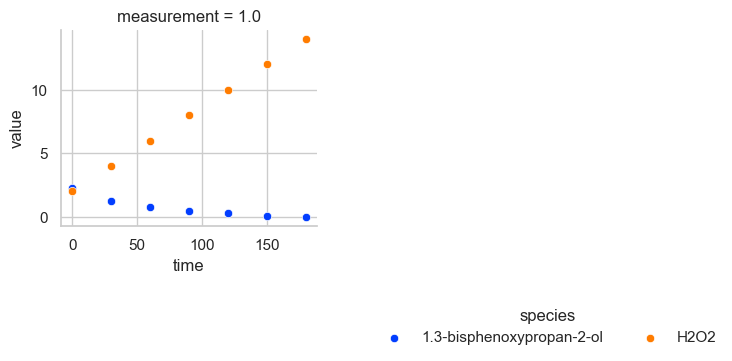

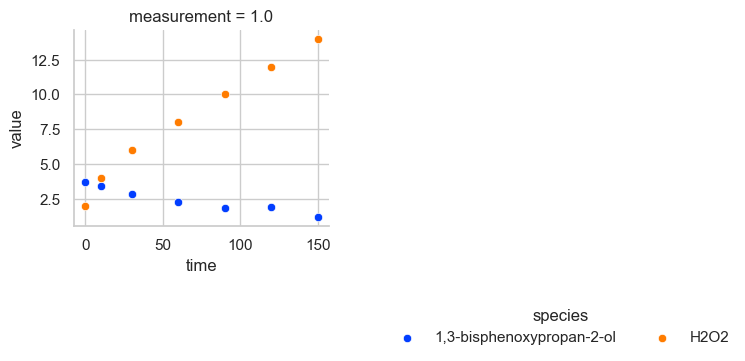

In [9]:
#basic/general settings for Seaborn
sns.set_theme(style='whitegrid', palette ='bright',color_codes=True, context = 'notebook')

round1.visualize(use_names=True)
round2.visualize(use_names=True)

## Prepare the data for modeling

Which Reactant should be modeled? This information can be seen in the output of printDocument()

In [10]:
reactant_id = 's0'

# Check if reactant_id is present
if reactant_id not in round1.getSpeciesIDs():
    print('Species not present')
    
# Exports species specific measurement data (dictionary)
measurement_data1 = round1.exportMeasurementData(species_ids=reactant_id)

# Concatenate data to a single DataFrame
measurement_data1 = pd.concat([meas["data"] for meas in measurement_data1.values()])

# Separate time and actual values to ndarrays
# Reshape to match measurements
time = measurement_data1.time.values.reshape(-1, len(measurement_data1.time.values))[0, :] # "-1" because it's an unknown dimension and we want numpy to figure it out
measurement_data1 = measurement_data1[reactant_id].values.reshape(-1, len(measurement_data1[reactant_id].values))[0, :] # -> converts 2D array to 1D  

# Exports species specific measurement data (dictionary)
measurement_data2 = round2.exportMeasurementData(species_ids=reactant_id)

# Concatenate data to a single DataFrame
measurement_data2 = pd.concat([meas["data"] for meas in measurement_data2.values()])

# Separate time and actual values to ndarrays
# Reshape to match measurements
time2 = measurement_data2.time.values.reshape(-1, len(measurement_data2.time.values)) # "-1" because it's an unknown dimension and we want numpy to figure it out
measurement_data2 = measurement_data2[reactant_id].values.reshape(-1, len(measurement_data2[reactant_id].values))[0, :] # -> converts 2D array to 1D  

print(f"Round 1 measurement data: {measurement_data1}\nRound 2 measurement data: {measurement_data2}\nTime: {time}")
measurement_data = np.array([measurement_data1, measurement_data2])

Round 1 measurement data: [2.27940386 1.23177972 0.76897022 0.49474677 0.29908216 0.04616504
 0.00590414]
Round 2 measurement data: [3.67826404 3.45657852 2.86866505 2.29359726 1.87556789 1.93547927
 1.21232926]
Time: [  0.  30.  60.  90. 120. 150. 180.]


## Kinetic modeling and parameter estimation

#### Functions that are needed in order to perform curve fitting

Execute this cell

In [27]:
# Compute residual between actual data (S) and fitted data, if data array has more than one dimension
from cProfile import label


def residual(params, t, data, model):

    # get dimensions of data (here we fit against 4 measurments => ndata = 4)
    ndata = data.shape[0]
    resid = 0.0 * data[:]  # initialize the residual vector
    time_new = np.array([[0,30,60,90,120,150,180], [0,10,30,60,90,120,150]])
    #time_new = np.array([[0,30,60,90,120,180], [0,10,30,60,90,150]])
    for i in range(ndata):
        
        w = (data[i,0], 0.0001)
        modelled = odeint(model, w, time_new[i], args=(params,))  # solve the ODE 
        
        # get modeled product
        modelled = modelled[:, 0]

        # compute distance to measured data
        resid[i, :] = data[i, :] - modelled
        
    return resid.flatten()


# This function gets called for residual calculation, if data array is one dimensional
def residual_single(params, t, measurement_data, model):
    
    w0 = measurement_data[0] # First value of measurement
    modelled = odeint(model, w0, t, args=(params,)) # g -> solving ODE 
    
    s_model = modelled[:,0] # 0th column
    
    return (s_model - measurement_data).ravel() # Return residuals


# Perform modeling
def perform_modeling(measurement_data, time, params, model):
    if len(measurement_data.shape)>1:
        result = minimize(residual, params, args=(time, measurement_data, model), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        plt.xlabel("Time [min]")
        plt.ylabel("Concentration [mmole / l]")
        plt.title('UPO-mediated oxidation of 1,3-bisphenoxypropan-2-ol', fontsize=15)
        label = ["1,3-bisphenoxypropan-2-ol [1st experiment]","1,3-bisphenoxypropan-2-ol [2nd experiment]"]
        time_new = np.array([[0,30,60,90,120,150,180], [0,10,30,60,90,120,150]])
        #time_new = np.array([[0,30,60,90,120,180], [0,10,30,60,90,150]])
        for i in range(measurement_data.shape[0]):
            plt.plot(time_new[i], measurement_data[i, :], 'o',label=label[i])
            w = (measurement_data[i,0], 0.0001)
            data_fitted = odeint(model, w, time_new[i], args=(result.params,))
            plt.plot(time_new[i], data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
    
    else:
        result = minimize(residual_single , params, args=(time, measurement_data, model), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        plt.plot(time, measurement_data[:], 'o')
        w0 = measurement_data[0]
        data_fitted = odeint(model, w0, time, args=(result.params,))
        plt.plot(time, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.show()

In order to model the data and perform parameter fitting, the kinetic equation for the model is defined as a Python function, along with a function to calculate the residual between the model and the measured data. <br>
<br>
In this case it is the Michaelis-Menten equation for one substrate

In [14]:
def model(w, t, params):
    cS = w[0]
    cE = w[1]
    
    k_cat = params['k_cat'].value
    Km = params['Km'].value
    K_ie = params["K_ie"].value

    dc_S = -k_cat * cE * (cS) / (Km+cS)
    dc_E = -K_ie * cE

    return (dc_S, dc_E)

#### Fit model and visualize results
Statistics for the Fit and the parameters are printed. <br>
In the graph the red line shows the result of the model. <br>
The dotted curves are the measured data sets.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 14
    # variables        = 3
    chi-square         = 0.22185093
    reduced chi-square = 0.02016827
    Akaike info crit   = -52.0272969
    Bayesian info crit = -50.1101249
[[Variables]]
    k_cat:  346.250118 +/- 35.9071176 (10.37%) (init = 350)
    Km:     0.01000000 +/- 0.04424506 (442.45%) (init = 1.3)
    K_ie:   0.01342876 +/- 0.00262253 (19.53%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_ie) = 0.881
    C(Km, K_ie)    = 0.344


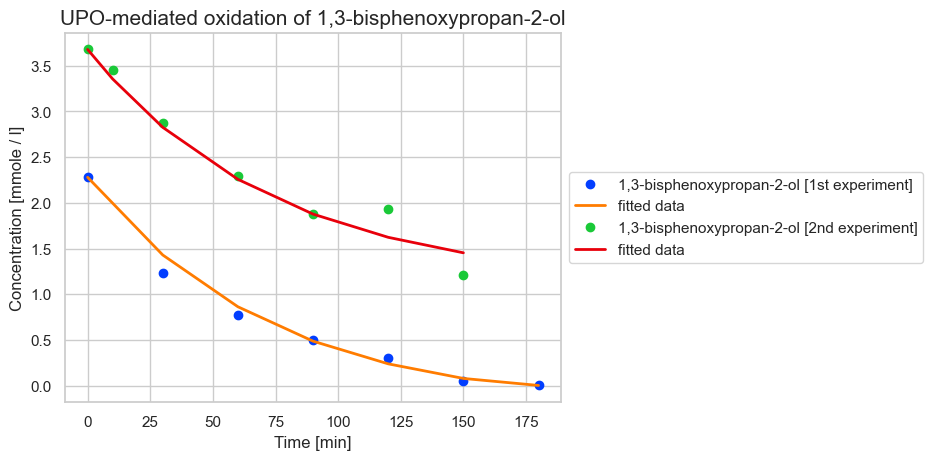

In [21]:
# Initialize parameters
params = Parameters() # Initialize a Parameters object from lmfit
params.add(name='k_cat', value=350, min=0.0001, max=1000.) # Add a parameter to the Parameters object
params.add(name='Km', value=1.3, min=0.01, max=1000) # Add another parameter to the Parameters object
params.add(name="K_ie", value=0.01, min=0.005, max=200)
'''
name = name of parameter
value = initial value of parameter
min = minimal value of parameter when fit is performed
max = maximal value of parameter when fit is performed
vary = False if parameter is constant, Standard -> True
'''

# Perform modeling
perform_modeling(measurement_data, time, params, model)

In [24]:
# Modeling without outlier
meas_data1_new = np.delete(measurement_data1, 5)
meas_data2_new = np.delete(measurement_data2, 5)
measurement_data_new = np.array([meas_data1_new, meas_data2_new])
print(measurement_data_new)

[[2.27940386 1.23177972 0.76897022 0.49474677 0.29908216 0.00590414]
 [3.67826404 3.45657852 2.86866505 2.29359726 1.87556789 1.21232926]]


In [25]:
time_new = np.delete(time, 5)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 12
    # variables        = 3
    chi-square         = 0.08808237
    reduced chi-square = 0.00978693
    Akaike info crit   = -52.9726741
    Bayesian info crit = -51.5179542
[[Variables]]
    k_cat:  346.760201 +/- 27.0684807 (7.81%) (init = 233.4172)
    Km:     0.08728595 +/- 0.07961546 (91.21%) (init = 0.01394172)
    K_ie:   0.01148157 +/- 0.00178834 (15.58%) (init = 0.00658674)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_ie) = 0.768
    C(k_cat, Km)   = 0.373
    C(Km, K_ie)    = -0.240


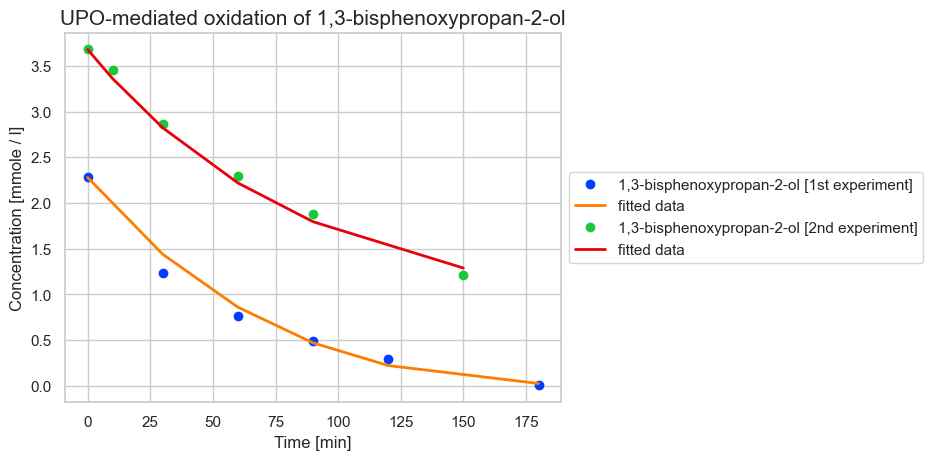

In [26]:
# Initialize parameters
params = Parameters() # Initialize a Parameters object from lmfit

params.add(name='k_cat', value=233.417186, min=0.1, max=450.) # Add a parameter to the Parameters object
params.add(name='Km', value=0.01394172, min=0.001, max=100) # Add another parameter to the Parameters object
params.add(name="K_ie", value=0.00658674, min=0.005, max=200)

# Perform modeling
perform_modeling(measurement_data_new, time_new, params, model)

## Additional information

### Pretty print

If pretty printing the experiment is necessary 

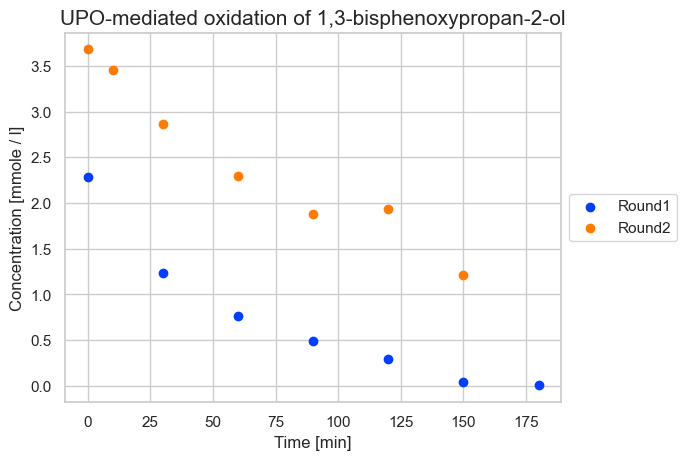

In [11]:
plt.scatter(time, measurement_data[0], label='Round1') # Declare the data that should be plotted
plt.scatter(time2, measurement_data[1], label='Round2')
plt.xlabel('Time [min]') # Set a x-axis label
plt.ylabel('Concentration [mmole / l]') # Set a y-axis label
plt.title('UPO-mediated oxidation of 1,3-bisphenoxypropan-2-ol', fontsize=15) # Set a title with specific fontsize
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # A legend outside the plot. Label is shown in legend
plt.show() # Print the plot

### Get meta information

In [ ]:
enzmldoc.measurement_dict # Get information from measurement

In [ ]:
enzmldoc.reaction_dict # Get information from reaction

In [ ]:
enzmldoc.reactant_dict # Get information from reactants